## Regression

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-04 01:33:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.009s  

2025-10-04 01:33:55 (93.6 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('car_fuel_efficiency.csv')[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

<Axes: >

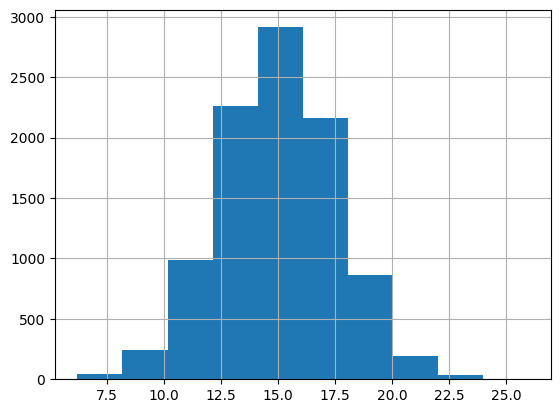

In [3]:
df['fuel_efficiency_mpg'].hist()

### Columns with missing values

In [4]:
df.columns[df.isna().any() == True]

Index(['horsepower'], dtype='object')

### Median horsepower

In [5]:
df['horsepower'].describe()['50%']

np.float64(149.0)

#### Shuffle Dataset

In [7]:
idx = np.arange(len(df))
np.random.seed(42)
np.random.shuffle(idx)

In [47]:
n_val = n_test = int(len(df) * 0.20)
n_train = len(df) - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

### Missing Value

In [48]:
class MissingValueHandler:
    def __init__(self):
        self.strategies = {
            'mean': self._fill_mean,
            'set_to_zero': self._set_to_zero
        }

    def handle_missing_vals(self, df: pd.DataFrame, column: str, strategy: str, **kwargs):

        handler = self.strategies.get(strategy)

        return handler(df=df, column_with_nulls=column, **kwargs)


    def _fill_mean(self, df, column_with_nulls, mean_val: float = None):
        df = df.copy()
        
        if mean_val:
            df[column_with_nulls] = df[column_with_nulls].fillna(mean_val)
        else:
            col_mean = np.nanmean(df[column_with_nulls].values)
            df[column_with_nulls] = df[column_with_nulls].fillna(col_mean)

        return df 
    
    def _set_to_zero(self, df, column_with_nulls):

        df = df.copy()
        df[column_with_nulls] = df[column_with_nulls].fillna(0)

        return df

In [49]:
handler = MissingValueHandler()

df_train_mean_fill = handler.handle_missing_vals(df_train, 'horsepower', "mean", mean_val = df_train['horsepower'].mean())
df_train_0_fill = handler.handle_missing_vals(df_train, 'horsepower', 'set_to_zero')

df_val_mean_fill = handler.handle_missing_vals(df_val, 'horsepower', "mean", mean_val = df_train['horsepower'].mean())
df_val_0_fill = handler.handle_missing_vals(df_val, 'horsepower', 'set_to_zero')

In [50]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [51]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

X_train_mean =  df_train_mean_fill[base]
y_train_mean = df_train_mean_fill['fuel_efficiency_mpg'].values

X_val_mean = df_val_mean_fill[base]
y_val_mean = df_val_mean_fill['fuel_efficiency_mpg'].values

w0_mean, w_mean = train_linear_regression(X_train_mean, y_train_mean)

y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

mean_na_fill_rmse = rmse(y_val_mean, y_pred_mean)

In [52]:
X_train_0 =  df_train_0_fill[base]
y_train_0 = df_train_0_fill['fuel_efficiency_mpg'].values

X_val_0 = df_val_0_fill[base]
y_val_0 = df_val_0_fill['fuel_efficiency_mpg'].values

w0_0, w_0 = train_linear_regression(X_train_0, y_train_0)

y_pred_0 = w0_0 + X_val_0.dot(w_0)

zero_na_fill_rmse = rmse(y_val_0, y_pred_0)

In [53]:
f"mean fill: {round(mean_na_fill_rmse, 2)}, zero fill:{round(zero_na_fill_rmse, 2)}"

'mean fill: 0.46, zero fill:0.51'

### Regularized models

In [54]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [55]:
reg_rmse_dict = {}

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train_0 =  df_train_0_fill[base]
    y_train_0 = df_train_0_fill['fuel_efficiency_mpg'].values

    X_val_0 = df_val_0_fill[base]
    y_val_0 = df_val_0_fill['fuel_efficiency_mpg'].values

    w0_0, w_0 = train_linear_regression_reg(X_train_0, y_train_0, r=r)

    y_pred_0 = w0_0 + X_val_0.dot(w_0)

    pred_rmse = rmse(y_val_0, y_pred_0)

    reg_rmse_dict[r] = pred_rmse 


    

In [56]:
dict(sorted(reg_rmse_dict.items(), key=lambda item: item[1]))

{0: np.float64(0.5131865908224594),
 0.01: np.float64(0.5132540656237305),
 0.1: np.float64(0.5158456588903589),
 1: np.float64(0.5197454617205501),
 5: np.float64(0.5204437154459186),
 10: np.float64(0.5205385240519984),
 100: np.float64(0.5206253825417081)}

### Shuffle seed

In [60]:
seed_rmse_lst = []

handler = MissingValueHandler()


for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(len(df))
    np.random.seed(seed)
    np.random.shuffle(idx)

    n_val = n_test = int(len(df) * 0.20)
    n_train = len(df) - n_val - n_test

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train_0_fill = handler.handle_missing_vals(df_train, 'horsepower', 'set_to_zero')
    df_val_0_fill = handler.handle_missing_vals(df_val, 'horsepower', 'set_to_zero')

    X_train_0 =  df_train_0_fill[base]
    y_train_0 = df_train_0_fill['fuel_efficiency_mpg'].values

    X_val_0 = df_val_0_fill[base]
    y_val_0 = df_val_0_fill['fuel_efficiency_mpg'].values

    w0_0, w_0 = train_linear_regression(X_train_0, y_train_0)

    y_pred_0 = w0_0 + X_val_0.dot(w_0)

    zero_na_fill_rmse = rmse(y_val_0, y_pred_0)

    seed_rmse_lst.append(zero_na_fill_rmse)
    
    

In [62]:
round(np.std(seed_rmse_lst),3)

np.float64(0.007)

### Combine validation and training datasets

In [63]:
idx = np.arange(len(df))
np.random.seed(9)
np.random.shuffle(idx)

n_test = int(len(df) * 0.20)
n_train_val = len(df) - n_test

df_train_val = df.iloc[idx[:n_train_val]]
df_test = df.iloc[idx[n_train_val:]]

df_train_val_0_fill = handler.handle_missing_vals(df_train_val, 'horsepower', 'set_to_zero')
df_test_0_fill = handler.handle_missing_vals(df_test, 'horsepower', 'set_to_zero')

X_train_val_0 =  df_train_val_0_fill[base]
y_train_val_0 = df_train_val_0_fill['fuel_efficiency_mpg'].values

X_test_0 = df_test_0_fill[base]
y_test_0 = df_test_0_fill['fuel_efficiency_mpg'].values

w0_0, w_0 = train_linear_regression_reg(X_train_val_0, y_train_val_0, r=0.001)

y_pred_0 = w0_0 + X_test_0.dot(w_0)

zero_na_fill_test_rmse = rmse(y_test_0, y_pred_0)

print(zero_na_fill_test_rmse)


0.5156261299169602
